# Classificador de Imagens usando TensorFlow Estimators

Neste notebook você irá implementadar um modelo para classificação de imagens, classificação é uma das aplicações de Machine Learning em que o ensino é **supervisionado**, em outras palavras nós vamos ensinar ao modelo através de exemplos em que já sabemos qual o resultado esperado.

Nosso modelo deverá receber imagens de gatos e cachorros e identificar a que **classe**(gato, cachorro) estas imagens pertencem.

## Dados

Os dados foram retirados da base de dados [CIFAR 10](https://www.cs.toronto.edu/~kriz/cifar.html) que contém 10000 imagens de 10 classes distintias, para este exemplo iremos utilizar apenas as classes gato e cachorro.

## Modelo

Iremos utilizar diferentes modelos com diferentes níveis de complexidade.


## Créditos

Essa atividade é baseada no notebook encontrado [aqui](https://github.com/random-forests/tensorflow-workshop/tree/master/extras/cat_dog_estimator) implementada originalmente por [@chrisying](https://github.com/chrisying). Obrigada a todos os envolvidos!

## Dependências

In [ ]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# TensorFlow
import tensorflow as tf

# Bibliotecas auxiliares
import cPickle  # maior eficiência ao processar as imagens
import numpy as np  # manipular vetores
from PIL import Image  # lidar com imagens
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

# IMPORTANTE: essa linha garante que os números gerados aleatoriamente são previsíveis
np.random.seed(0)

print ('Sua versão do TensorFlow:', tf.__version__)
print ('Recomenda-se para esta atividade uma versão >= 1.4.0')

## Buscando os Dados

### Baixa e estraia os dados

Para baixar os dados, execute os seguintes comandos na pasta em que se encontra este notebook.

```bash
curl -O http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar xvf cifar-10-python.tar.gz
```

Ou você pode baixar os dados manualmente [clicando neste link](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) e extraí-los nesta pasta.

Após extrair as pastas você deverá ver as seguintes subpastas:

```bash
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
```

## Salvando as imagens no formato .npy

Para facilitar a manipulação das imagens iremos salvá-las como vetores utilizando a [biblioteca Numpy](http://www.numpy.org/) que é muito fácil de se trabalhar além de ser altamente compatível com o TensorFlow.


In [ ]:
ARQUIVOS_TREINO = ['cifar-10-batches-py/data_batch_%d' % i for i in range(1,6)]
ARQUIVOS_TESTE = ['cifar-10-batches-py/test_batch']

NUM_DADOS_TREINO = 10000
NUM_DADOS_TESTE = 2000

LABEL_INPUT_GATO = 3
LABEL_INPUT_CACHORRO = 5

LABEL_OUTPUT_GATO = 1
LABEL_OUTPUT_CACHORRO = 0

def unpickle(file):
    '''Essa função apenas torna mais eficiente a manipulação dos dados, não se preocupe em entendê-la a fundo.'''
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
        return dict
    
def converter_para_numpy(arquivos, num_dados, saida_numpy):
    '''Essa função converte os arquivos de treino e teste em arquivos .npy'''
    
    # Recupera cada dado (imagem, label) nos arquivos
    dados = [unpickle(a) for a in arquivos]

    # Salva as imagens e labels em arrays numpy
    imagens = np.empty((num_dados, 32, 32, 3), dtype=np.uint8)
    labels = np.empty((num_dados), dtype=np.uint8)

    index = 0
    for d in dados:
        for batch_index, label in enumerate(d['labels']):
            # Caso a imagem seja classificada como gato ou cachorro a consideramos
            if label == LABEL_INPUT_GATO or label == LABEL_INPUT_CACHORRO:
                # Os dados originais são armazenados no formato 1 x 3072 , convertemos para 32 x 32 x 3
                imagens[index, :, :, :] = np.transpose(
                  np.reshape(d['data'][batch_index, :],
                  newshape=(3, 32, 32)),
                  axes=(1, 2, 0))
                # Salvamos o label de saída correto
                if label == LABEL_INPUT_GATO:
                    labels[index] = LABEL_OUTPUT_GATO
                else:
                    labels[index] = LABEL_OUTPUT_CACHORRO
                index += 1

    # Salvamos no arquivo de saída
    np.save(saida_numpy, {'imagens': imagens, 'labels': labels})

# Convertemos os arquivos de treino
converter_para_numpy(ARQUIVOS_TREINO, NUM_DADOS_TREINO, 'treino.npy')
# Convertemos os arquivos de teste
converter_para_numpy(ARQUIVOS_TESTE, NUM_DADOS_TESTE, 'teste.npy')

## Verificando se dados foram salvos corretamente

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente. Para isto vamos escolher algumas imagens do conjunto de treino aleatoriamente e verificá-las.

> IMPORTANTE: para modelos reais é importante garantir a qualidade e integridade dos dados com maior rigor já que é fundamental a "saúde" dos dados para se obter um bom modelo.


In [3]:
dados_treino = np.load('treino.npy').item()
# NÃO DEVEMOS OLHAR/MEXER NOS DADOS DE TESTE. SÓ UTILIZAREMOS ESTES DADOS PARA VALIDAR NOSSO
# MODELO DEPOIS DO TREINO.
dados_teste = np.load('teste.npy').item()

In [7]:
print ('Formato das imagens de treino:', dados_treino['imagens'].shape)
print ('Formato das labels de treino:', dados_treino['labels'].shape)
print ('-' * 50)
print ('Formato das imagens de teste:', dados_teste['imagens'].shape)
print ('Formato das labels de teste:', dados_teste['labels'].shape)

Formato das imagens de treino: (10000, 32, 32, 3)
Formato das labels de treino: (10000,)
--------------------------------------------------
Formato das imagens de teste: (2000, 32, 32, 3)
Formato das labels de teste: (2000,)


Exemplos de 5 imagens de teste


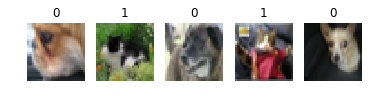

In [8]:
def visualizar_dados_treino(num_dados):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_dados (int): número de dados que serão apresentados 
    '''

    print('Exemplos de %d imagens de teste' % num_dados)
    
    # Escolhe índices aleatórios
    random_indices = np.random.randint(0, dados_treino['imagens'].shape[0], num_dados)
    imagens = dados_treino['imagens'][random_indices]
    labels = dados_treino['labels'][random_indices]
    for index, (img, label) in enumerate(zip(imagens, labels)):
        plt.subplot(2, num_dados, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%i' % label)
    plt.show()

visualizar_dados_treino(5)

## Treinando o modelo

In [20]:
# Checkpoints e logs serão salvos nessa paste, se quiser treinar do zero
# delete a pasta ou tudo que tem nela.
MODEL_DIR = 'models'

# Hiper parâmetros
LEARNING_RATE = 0.01
MOMENTUM = 0.9
TRAIN_EPOCHS = 5
BATCH_SIZE = 32

def model_fn(features, labels, mode):
  """Defines the CNN model that runs on the data.

  The model we run is 3 convolutional layers followed by 1 fully connected
  layer before the output. This is much simpler than most CNN models and is
  designed to run decently on CPU. With a GPU, it is possible to scale to
  more layers and more filters per layer.

  Args:
      features: batch_size x 32 x 32 x 3 uint8 images
      labels: batch_size x 1 uint8 labels (0 or 1)
      mode: TRAIN, EVAL, or PREDICT

  Returns:
      EstimatorSpec which defines the model to run
  """

  # Preprocess the features by converting to floats in [-0.5, 0.5]
  features = tf.cast(features, tf.float32)
  features = (features / 255.0) - 1.0

  # Define the CNN network
  # conv1: 32 x 32 x 3 -> 32 x 32 x 16
  net = tf.layers.conv2d(
      inputs=features,
      filters=16,                 # 16 channels after conv
      kernel_size=3,              # 3x3 conv kernel
      padding='same',             # Output tensor is same shape
      activation=tf.nn.relu)      # ReLU activation

  # pool1: 32 x 32 x 16 -> 16 x 16 x 16
  net = tf.layers.max_pooling2d(
      inputs=net,
      pool_size=2,
      strides=2)                  # Downsample 2x

  # conv2: 16 x 16 x 16 -> 16 x 16 x 32
  net = tf.layers.conv2d(
      inputs=net,
      filters=32,
      kernel_size=3,
      padding='same',
      activation=tf.nn.relu)

  # pool2: 16 x 16 x 32 -> 8 x 8 x 32
  net = tf.layers.max_pooling2d(
      inputs=net,
      pool_size=2,
      strides=2)

  # conv3: 8 x 8 x 32 -> 8 x 8 x 64
  net = tf.layers.conv2d(
      inputs=net,
      filters=64,
      kernel_size=3,
      padding='same',
      activation=tf.nn.relu)

  # flat: 8 x 8 x 64 -> 4096
  net = tf.contrib.layers.flatten(net)

  # fc4: 4096 -> 1000
  net = tf.layers.dense(
      inputs=net,
      units=1000,
      activation=tf.nn.relu)

  # output: 1000 -> 2
  logits = tf.layers.dense(
      inputs=net,
      units=2)

  # Softmax for probabilities
  probabilities = tf.nn.softmax(logits)

  predictions = tf.argmax(
      input=logits,
      axis=1,
      output_type=tf.int32)

  # Return maximum prediction if we're running PREDICT
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'prediction': predictions,
            'probability': probabilities})

  # Loss function and optimizer for training
  loss = tf.losses.softmax_cross_entropy(
      onehot_labels=tf.one_hot(labels, depth=2),
      logits=logits)

  train_op = tf.train.MomentumOptimizer(
      LEARNING_RATE, MOMENTUM).minimize(
          loss=loss,
          global_step=tf.train.get_global_step())

  # Accuracy for evaluation
  eval_metric_ops = {
      'accuracy': tf.metrics.accuracy(
          labels=labels,
          predictions=predictions)}

  # EVAL uses loss and eval_metric_ops, TRAIN uses loss and train_op
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

def input_fn_wrapper(is_training, dados):
  """Input function wrapper for training and eval.

  A wrapper funcution is used because we want to have slightly different
  behavior for the dataset during training (shuffle and loop data) and
  evaluation (don't shuffle and run exactly once).

  Args:
      is_training: bool for if the model is training

  Returns:
      function with signature () -> features, labels
      where features and labels are the same shapes expected by model_fn
  """
  def input_fn():
    np_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'x': dados['imagens']},
        y=dados['labels'],
        batch_size=BATCH_SIZE,
        shuffle=is_training,
        num_epochs=None if is_training else 1)

    features_dict, labels = np_input_fn()
    # Since the only feature is the image itself, return the image directly
    # instead of the features dict
    return features_dict['x'], labels

  return input_fn

tf.logging.set_verbosity(tf.logging.INFO)

# Create the estimator object that is used by train, evaluate, and predict
# Note that model_fn is not called until the first usage of the model.
estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=tf.estimator.RunConfig().replace(
      model_dir=MODEL_DIR))

steps_per_epoch = dados_treino['imagens'].shape[0] / BATCH_SIZE

for epoch in xrange(TRAIN_EPOCHS):
  estimator.train(
      input_fn=input_fn_wrapper(True, dados_treino),
      steps=steps_per_epoch)
  # Evaluating on the same dataset as training for simplicity, normally
  # this is a very bad idea since you are not testing how well your
  # model generalizes to unseen data.
  estimator.evaluate(input_fn=input_fn_wrapper(False, dados_teste))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2b30123850>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into models/model.ckpt.
INFO:tensorflow:loss = 0.680092, step = 1
INFO:tensorflow:global_step/sec: 8.95124
INFO:tensorflow:loss = 0.685584, step = 101 (11.173 sec)
INFO:tensorflow:global_step/sec: 9.02329
INFO:tensorflow:loss = 0.714652, step = 201 (11.082 sec)
INFO:tensorflow:global_step/sec: 9.33689
INFO:tensorflow:loss = 0.672315, step = 301 (10.710 sec)
INFO:tensorflow:Saving c

In [23]:

def process_image(image_file):
  """Convert PIL Image to a format that the network can accept.

  Operations performed:
      - Load image file
      - Central crop square
      - Resize to 32 x 32
      - Convert to numpy array

  Args:
      image_file: str file name of image

  Returns:
      numpy.array image which shape [1, 32, 32, 3]

  Assumes that image is RGB and at least 32 x 32.
  """
  image = Image.open(image_file)
  width, height = image.size

  min_dim = min(width, height)
  left = (width - min_dim) / 2
  top = (height - min_dim) / 2
  right = (width + min_dim) / 2
  bottom = (height + min_dim) / 2

  image = image.crop((left, top, right, bottom))
  image = image.resize((32, 32), resample=Image.BILINEAR)
  image = np.asarray(image, dtype=np.uint8)
  image = np.reshape(image, [1, 32, 32, 3])

  return image

image = process_image('dog.jpg')
# Define a new input function for prediction which outputs a single image
def predict_input_fn():
  np_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'x': image},
      num_epochs=1,
      shuffle=False)
  features_dict = np_input_fn()
  return features_dict['x']

pred_dict = estimator.predict(
    input_fn=predict_input_fn).next()

print ('Probability of cat: %.5f\tProbability of dog: %.5f' % (pred_dict['probability'][1], pred_dict['probability'][0]))
print ('Prediction %s' % ('CAT' if pred_dict['prediction'] == 1 else 'DOG'))


INFO:tensorflow:Restoring parameters from models/model.ckpt-1565
Probability of cat: 0.00412	Probability of dog: 0.99588
Prediction DOG
